In [2]:

import numpy as np
import pandas as pd
import seaborn as sns
import ast as ast
import matplotlib.cm as cm
from geopy.distance import geodesic
import scipy.stats as sps
import networkx as nx
import matplotlib
import math
import mysql.connector
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (20,15)

In [3]:
def pos_insee(G,data):
    pos = {} #dictionnaire vide
    for com in G.nodes:
        y = float(data[data['Code Officiel Commune'] == com]['Latitude'].iloc[0])
        x = float(data[data['Code Officiel Commune'] == com]['Longitude'].iloc[0])
        #on peut adapter les coordonnées
        #x=(x- 48.13380133652042)*1000
        #y=(y+2.287539276431153)*1000
    
        pos[com]=[x,y]
    
    return pos


def label_insee(G,data):
    label = {} #dictionnaire vide
    for com in G.nodes:
        lab = data[data['Code Officiel Commune'] == com]['Nom Officiel Commune'].iloc[0]
        label[com]=lab
    
    return label

def amezek(com):
    voisins = [int(num) for num in communes['insee_voisins'][com].split('|')]
    amezek = []
    for vois in voisins :
        if (22000 <= vois and vois<23000) or (29000 <= vois and vois<30000) or (35000 <= vois and vois<36000) or (56000 <= vois and vois<57000) : #on reste en bretagne
            if vois != communes['insee'][com] : #boucle
                amezek.append(vois)
    return amezek

On établie d'abord des fonctions nous permettant de tracer les graphes correctement, en créant des dictionnaires avec la position ainsi que le numéro Insee pour chaque commune. On enlève aussi les communes hors de la Bretagne des communes voisines à celle située aux bords.

In [4]:

def affichageGraphe(C,label):
    cent = np.fromiter(c.values(), float)
    sizes = cent / np.max(cent) * 200
    colormap = cm.viridis

    # Utilisation de subplots pour mieux gérer la disposition
    fig, ax = plt.subplots(figsize=(20, 15))  # Taille plus grande pour plus d'espace


    nx.draw(G, pos_insee, node_size=50, node_color=sizes, cmap=colormap, ax=ax)

    # Ajout d'un colorbar à côté du graphe
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
    scalarmappaple = cm.ScalarMappable(cmap=colormap)
    cbar = fig.colorbar(scalarmappaple, cax=cbar_ax)
    cbar.set_ticks(ticks=[0, 1], labels=[min(c.values()), max(c.values())])
    cbar.set_label(label)

    plt.show()


On définie une méthode que l'on utilisera pour chaque affichage de graphe, elle possède donc plusieurs paramètre pour fonctionner dans toutes les situations. Avec "c" un dictionnaire avec pour clé le numéro Insee d'une commune et en valeur l'indicateur qu'on souhaite représenter sur le graphe, ainsi qu'un label pour afficher la légende sur le graphe. Cette fonction ajoute aussi une color bar sur la droite du graphe, nous permettant de mieux visualiser les données.

In [5]:
communes=pd.read_csv("./DonneesFourniesGraphes/voisinageCommunesBretonnes.csv", sep=';')
voisins_dict = {communes['insee'][x] : amezek(x) for x in range(len(communes['insee']))}

On lit les données à partir du fichier csv et on créé un dictionnaire qui associe à chaque commune son code INSEE et la liste de ses voisins.

In [6]:
G = nx.from_dict_of_lists(voisins_dict)

On créé un graphe G à partir de ce dictionnaire de voisin grâce a la bibliothèque networkx

In [7]:
geo=pd.read_csv("./DonneesFourniesGraphes/communes-geo.csv", sep=';')
geo_lite = geo.iloc[:,[0,1,17,19]]
ast.literal_eval(geo_lite['Geo Point'][0])
geo_lite['Latitude']=geo_lite['Geo Point'].apply(lambda x : ast.literal_eval(x)[0])
geo_lite['Longitude']=geo_lite['Geo Point'].apply(lambda x : ast.literal_eval(x)[1])

pos_insee = pos_insee(G,geo_lite)
label_insee = label_insee(G,geo_lite)

On lit à partir d'une autre fichier csv les coordonnées des communes.

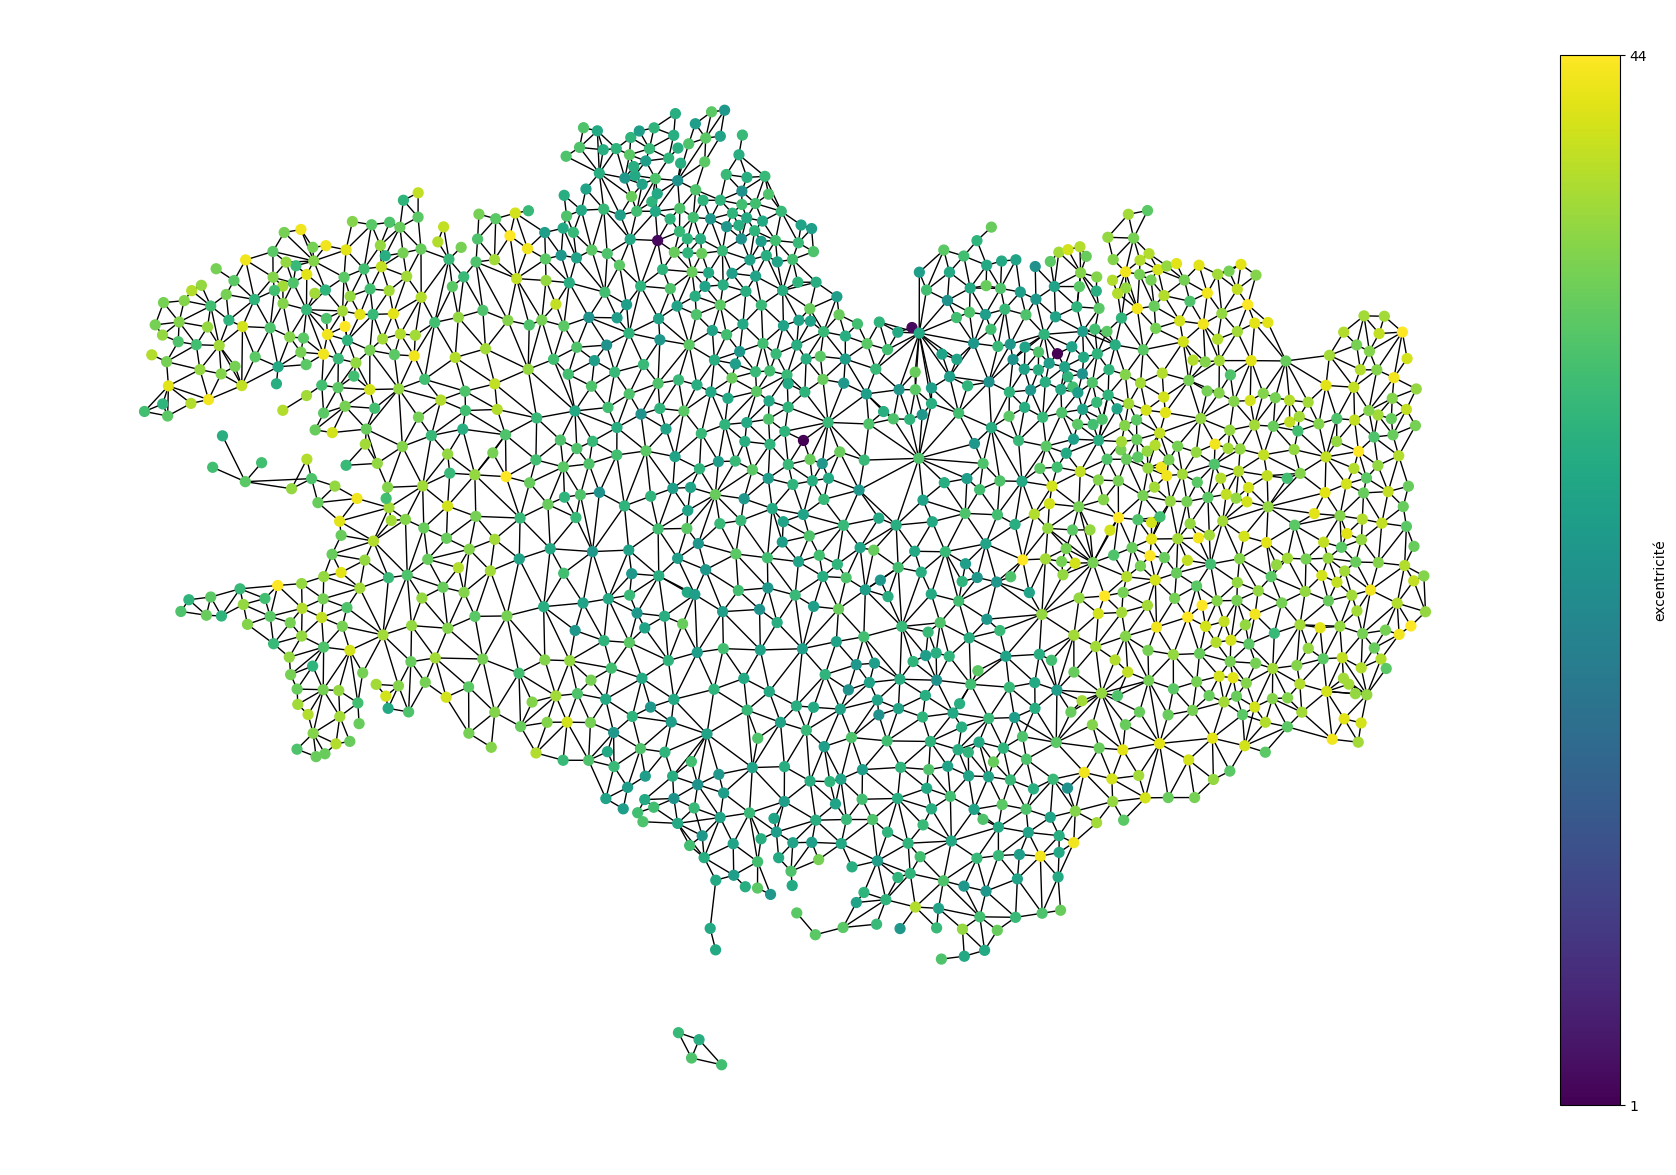

In [8]:
def excentricity(G):
    dico = {}
    dico[56009] = 2
    dico[56241] = 2
    dico[56152] = 2
    dico[56114] = 2

    for node1 in G.nodes:
        length = nx.shortest_path_length(G, source=node1)
        dico[node1] = max(length.values())

    return dico


c = excentricity(G)

affichageGraphe(c,"excentricité")



L'excentricité permet de mesurer la distance maximale entre une commune et toutes les autres communes du réseau. En analysant l'excentricité, nous pouvons identifier les communes qui sont géographiquement centrales et celles qui sont périphériques. Les communes avec une faible excentricité sont potentiellement plus attractives, car elles sont facilement accessibles depuis n'importe quel autre point du réseau, ce qui favorise les interactions économiques, sociales et culturelles.

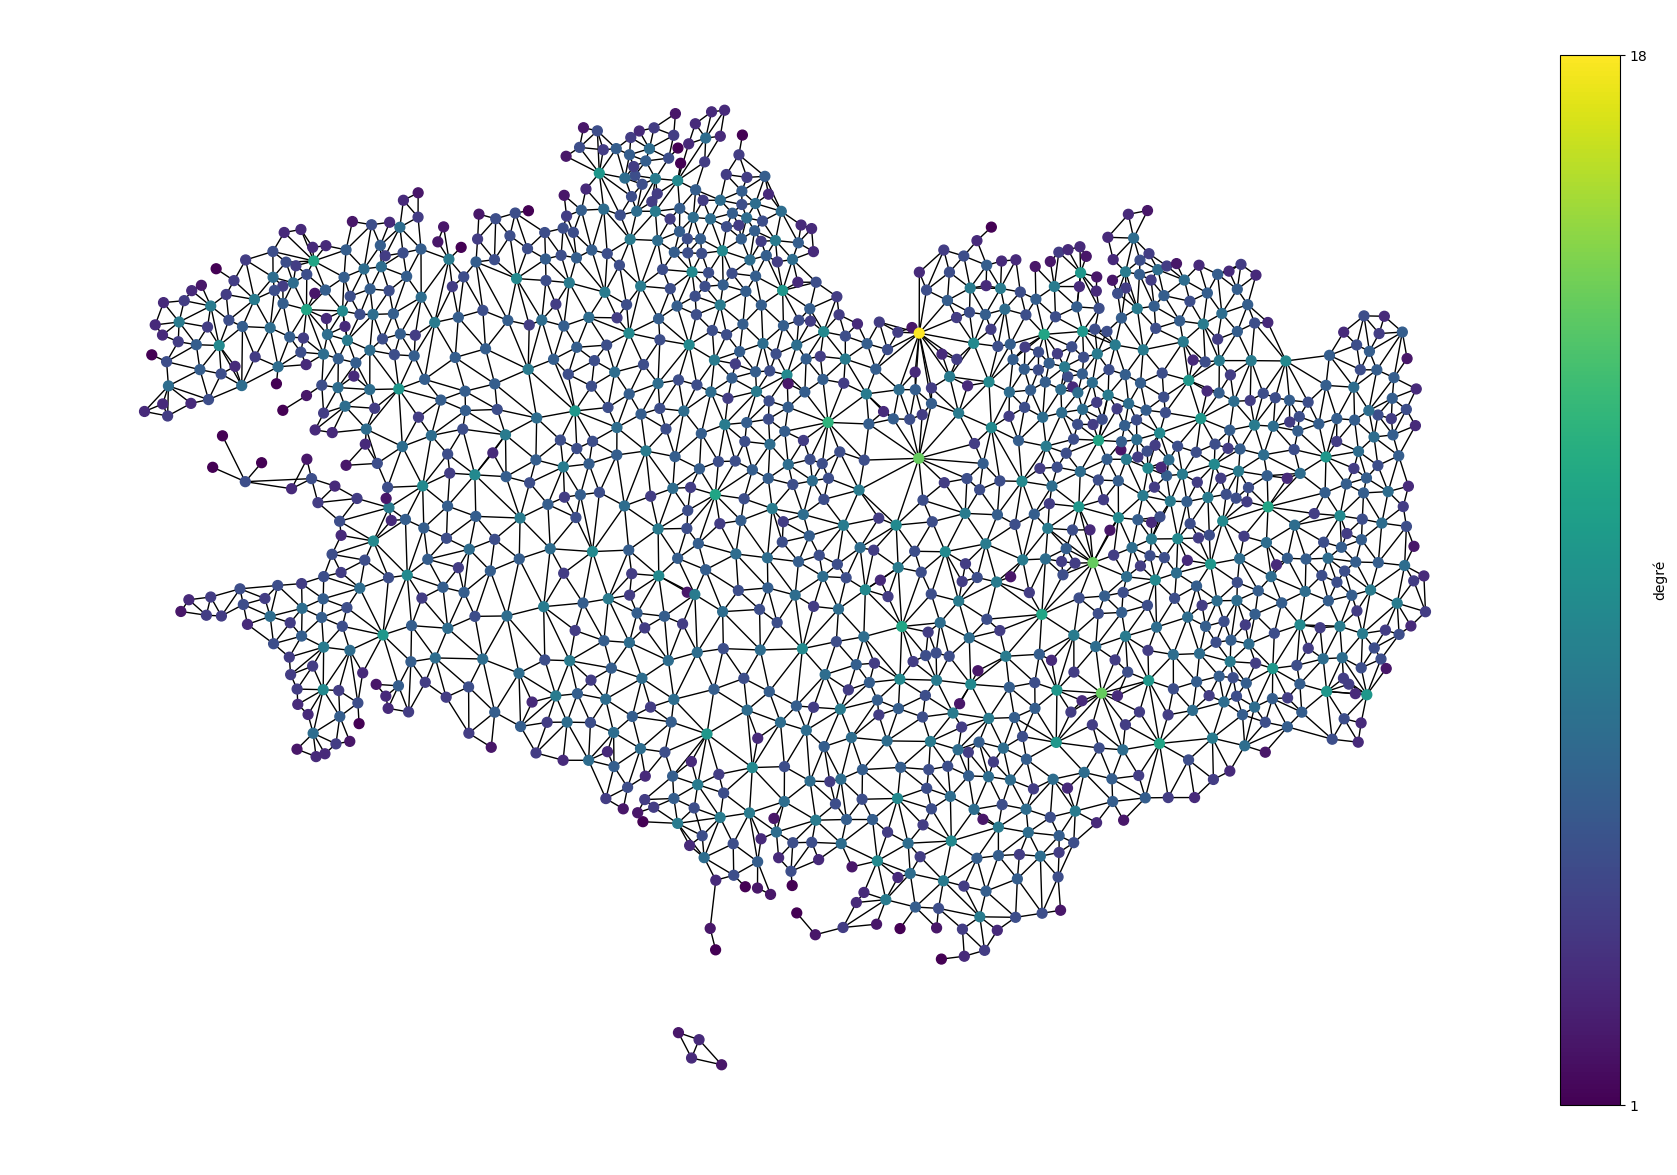

In [9]:
def degree(G):
    dico = {}
    for node1 in G.nodes:
        dico[node1] = G.degree(node1)
    return dico

c = degree(G)

affichageGraphe(c,"degré")

Le degré d'une commune (le nombre de connexions directes avec d'autres communes) est un indicateur clé de son intégration dans le réseau. Un degré élevé indique une commune bien connectée, suggérant une forte capacité d'interaction et de collaboration avec les communes voisines. Cette intégration peut attirer des résidents et des entreprises cherchant à bénéficier de ces multiples connexions pour les opportunités économiques et les services disponibles.

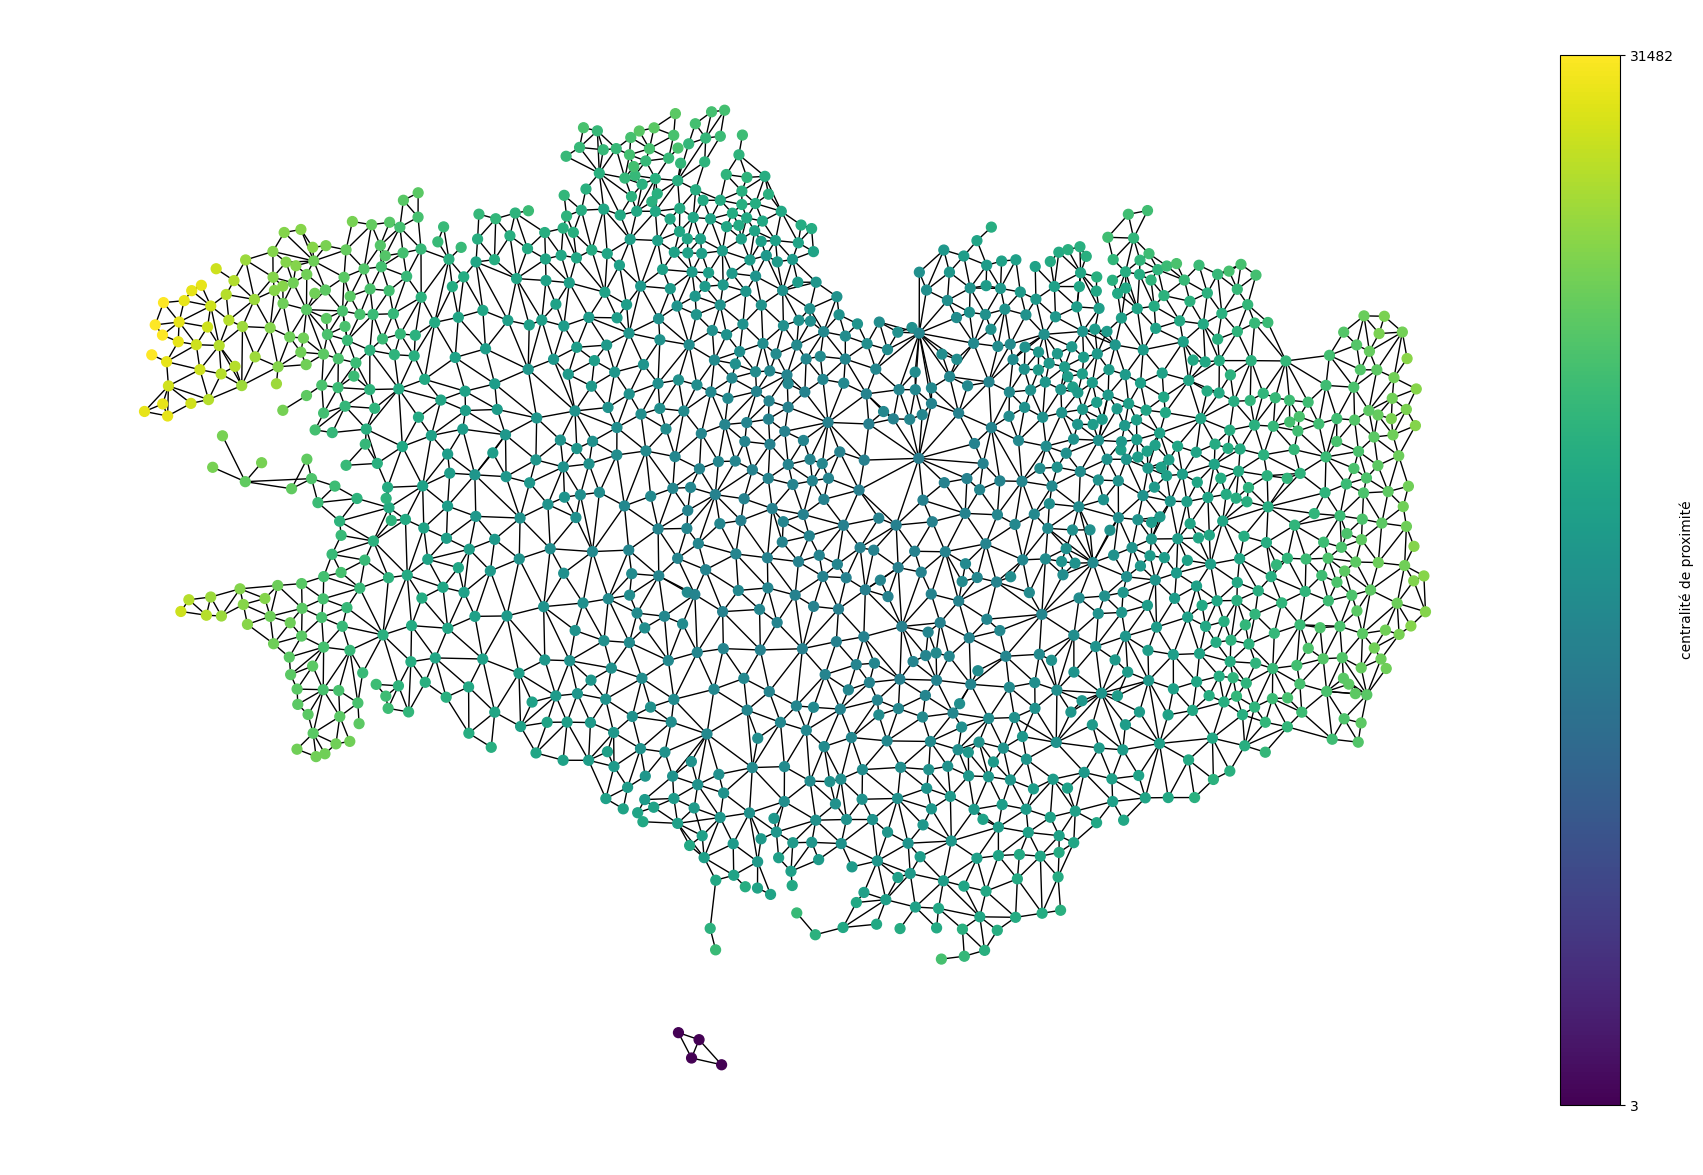

In [10]:
def centraliteDeProximite(G):
    dico = {}
    for node1 in G.nodes:
        length = nx.shortest_path_length(G, source=node1)
        dico[node1] = sum(length.values())
    return dico

c = centraliteDeProximite(G)

affichageGraphe(c,"centralité de proximité")

La centralité de proximité évalue à quel point une commune est proche de toutes les autres communes en termes de distances moyennes. Une haute centralité de proximité indique que la commune est facilement accessible, ce qui est un atout majeur pour l'attractivité. Cela facilite les déplacements pour les résidents, les échanges commerciaux et l'accès aux services publics, rendant la commune plus désirable pour vivre et investir.

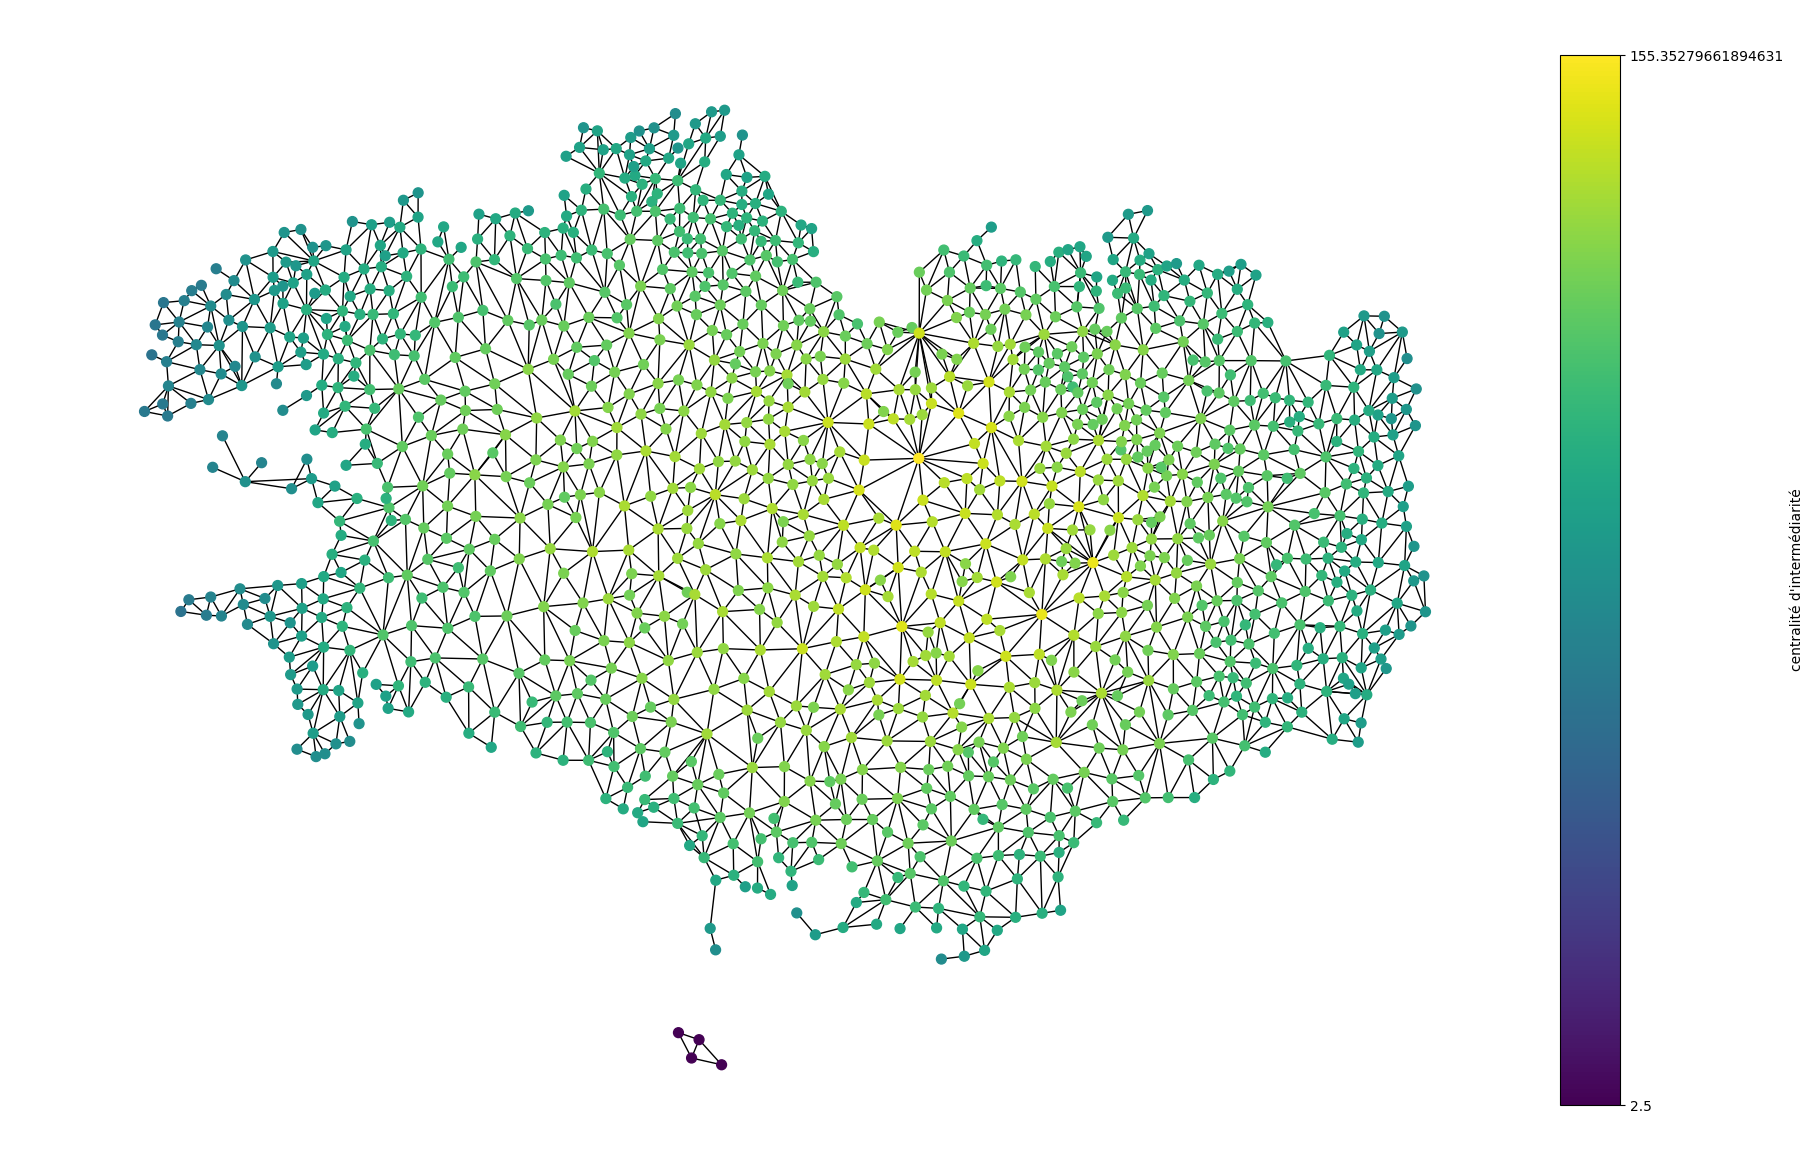

In [11]:
def centraliteIntermediarite(G):
    dico = {}
    for node1 in G.nodes:
        length = nx.shortest_path_length(G, source=node1)
        dico[node1] = sum(1/val if val != 0 else 0 for val in length.values())
    return dico

c = centraliteIntermediarite(G)

affichageGraphe(c,"centralité d'intermédiarité")

La centralité d'intermédiarité mesure la fréquence à laquelle une commune se trouve sur les chemins les plus courts reliant d'autres communes. Cette mesure est essentielle pour identifier les communes qui jouent un rôle crucial dans les flux de transport et de communication au sein du réseau. Une haute centralité d'intermédiarité signifie que la commune est un point de passage stratégique, ce qui peut attirer des entreprises de logistique, des commerces et des services de transit, augmentant ainsi son attractivité.

En utilisant ces quatre indicateurs, nous obtenons une vision multidimensionnelle de l'attractivité des communes :

L'excentricité nous informe sur la centralité géographique et l'accessibilité globale.
Le degré reflète le niveau de connectivité directe et l'intégration dans le réseau.
La centralité de proximité évalue l'accessibilité relative aux autres communes.
La centralité d'intermédiarité révèle l'importance stratégique dans les flux de communication et de transport.

In [12]:
baseDeDonnees = mysql.connector.connect(host="localhost",user="root",password="root", database="test")
cursor = baseDeDonnees.cursor()
cursor.execute("Select * from donneesannuelles")
donneesannuelles = cursor.fetchall()
cursor.execute("Select * from gare")
gare = cursor.fetchall()
cursor.execute("Select * from aeroport")
aeroport = cursor.fetchall()
baseDeDonnees.close()

ProgrammingError: 1049 (42000): Unknown database 'test'

Les fichiers csv contenait assez d'informations pour utiliser des indicateurs de théorie des graphes intéressant, néanmoins d'autre indicateur peuvent l'être tout autant, mais pour cela il nous faut plus de donner. À l'aide de la bibliothèque MySQL, on récupère toutes les données de l'application qu'on a stockées dans une base de données afin de pouvoir les utiliser des graphes.  

<p style="color:red;"><b>ATTENTION !</b></p>
Il faut donc avoir une base de données qui contient les données de l'application.
Sur la première ligne, il faudra remplacer l'user, le password et le nom de la base de données en marche sur votre machine.

In [ ]:
def affichageDonnees(donnees,annee):
    dico = {}
    for e in donneesannuelles:
        if e[1] in G.nodes:
            if e[0] == annee:
                dico[e[1]] = e[donnees]

    average = sum(dico.values())/len(dico)
    dico[22108] = average
    dico[22139] = average
    dico[22276] = average
    dico[22335] = average
    dico[35354] = average
    return dico


listeName = ["nbMaison","nbAppart","PrixMoyen","PrixM2Moyen","SurfaceMoyenne","DepenseCulturelleTotale","Budget total","population"]
for i in range(2,10):
    c = affichageDonnees(i,2019)
    affichageGraphe(c,listeName[i-2])

À partir de notre base de données, on affiche les graphes qui montrent pour chaque commune.

Nombre de maisons ("nbMaison") :
Le nombre de maisons dans une commune donne une idée du type de logement prédominant et de l'espace disponible pour les familles. Une proportion élevée de maisons peut indiquer un environnement résidentiel attrayant, souvent associé à plus d'espace, de jardins, et de quartiers paisibles, ce qui peut attirer les familles et les personnes cherchant une meilleure qualité de vie.

Nombre d'appartements ("nbAppart") :
Le nombre d'appartements reflète la densité résidentielle et la disponibilité de logements plus petits. Cela peut attirer des jeunes professionnels, des célibataires, ou des couples sans enfants, cherchant des options de logement abordables et pratiques, souvent situées à proximité des services urbains.

Prix moyen des logements ("PrixMoyen") :
Le prix moyen des logements est un indicateur clé du coût de la vie et de l'accessibilité financière. Des prix plus bas peuvent attirer des résidents à la recherche de logements abordables, tandis que des prix plus élevés peuvent indiquer une forte demande et une attractivité perçue de la commune.

Prix moyen au mètre carré ("PrixM2Moyen") :
Le prix moyen au mètre carré fournit une mesure plus précise de la valeur immobilière, permettant de comparer les communes indépendamment de la taille des logements. C'est un indicateur important pour les acheteurs potentiels et les investisseurs immobiliers évaluant la rentabilité de leurs investissements.

Surface moyenne des logements ("SurfaceMoyenne") :
La surface moyenne des logements informe sur le type de logements disponibles et le confort des résidences. Des surfaces moyennes, plus grandes peuvent attirer les familles et ceux recherchant plus d'espace, tandis que des surfaces plus petites peuvent convenir à des jeunes adultes ou des personnes seules.

Dépense culturelle totale ("DepenseCulturelleTotale") :
La dépense culturelle totale indique l'engagement de la commune envers les activités culturelles et les loisirs. Une dépense élevée peut refléter une riche offre culturelle, ce qui est un facteur d'attractivité important pour les résidents intéressés par les arts, la culture et les événements communautaires.

Budget total de la commune ("Budget total") :
Le budget total de la commune est un indicateur de sa capacité financière à fournir des services et des infrastructures. Une commune avec un budget important peut offrir de meilleurs services publics, des infrastructures de qualité et investir dans le développement local, augmentant ainsi son attractivité.

Population :
La population d'une commune est un indicateur de sa taille et de son dynamisme démographique. Une population croissante peut indiquer une attractivité accrue, tandis qu'une population stable ou en déclin peut signaler des défis économiques ou sociaux. La taille de la population est également importante pour planifier les services et les infrastructures nécessaires.


Ces indicateurs permettent de couvrir une vaste gamme de facteurs influençant l'attractivité des communes :

Logement : "nbMaison", "nbAppart", "PrixMoyen", "PrixM2Moyen", "SurfaceMoyenne" fournissent des informations sur le marché immobilier, les types de logements disponibles, et le coût de la vie.

Culture et services : "DepenseCulturelleTotale" et "Budget total" reflètent l'engagement de la commune à offrir des services et des activités qui enrichissent la vie des résidents.

Démographie : La "population" aide à comprendre le dynamisme et la croissance de la commune.

In [ ]:
def distanceGare():
    nopeList = [56009, 56241, 56152, 56114]

    dico = {}
    nodeGare = []
    for e in gare:
        nodeGare.append(e[4])
        
    for e in G.nodes:
        if e not in nopeList:
            d = math.inf
            for e2 in nodeGare:
                calc = nx.shortest_path_length(G, source=e, target=e2)
                if calc < d:
                    d = calc
            dico[e] = d
        else:
            dico[e] = 8
    
    return dico

c = distanceGare()


affichageGraphe(c,"distance à la gare la plus proche")

La distance à la gare la plus proche est un indicateur crucial de l'attractivité des communes. Une proximité avec une gare améliore l'accessibilité et la mobilité des résidents, facilitant les déplacements quotidiens pour le travail, les études et les loisirs. Cela encourage également le développement économique en attirant des entreprises grâce à une meilleure logistique et à un accès facilité aux marchés. De plus, un bon accès aux transports en commun réduit la nécessité de posséder une voiture, abaissant ainsi les coûts de transport et contribuant à un mode de vie plus durable. Enfin, la proximité d'une gare rend la commune plus accessible aux touristes, stimulant l'économie locale par l'augmentation des visiteurs et des dépenses associées.

In [15]:
#colorie les chemin le plus cour pour aller a une gare avec prim et affiche le graphe

def coloreGare():
    nopeList = [56009, 56241, 56152, 56114]

    dico = {}
    nodeGare = []
    for e in gare:
        nodeGare.append(e[4])
        
    for e in G.nodes:
        if e not in nopeList:
            d = math.inf
            for e2 in nodeGare:
                calc = nx.shortest_path_length(G, source=e, target=e2)
                if calc < d:
                    d = calc
            dico[e] = d
        else:
            dico[e] = 8
    
    return dico

affichageGraphe(coloreGare,"distance à la gare la plus proche")